## Version Information

<table align="left">
  <thead>
    <tr>
      <th>Component</th>
      <th>Version</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>python</td>
      <td>3.11.5</td>
    </tr>
    <tr>
      <td>pytket</td>
      <td>1.28.0</td>
    </tr>
  </tbody>
</table>

</table>


In [3]:
from pytket import Circuit
from qiskit.circuit.library import QFT
from pytket.extensions.qiskit import tk_to_qiskit, qiskit_to_tk, AerBackend
from pytket.circuit.display import render_circuit_jupyter
from sympy import isprime
import math
from pytket.backends.backendresult import BackendResult
from fractions import Fraction
import random

from datetime import datetime
import numpy as np
import time


In [4]:
from my_functions import *

In [5]:
def initiate_qc(N):
    # identify n-length and m-length
    n_len, m_len = get_nlen_mlen(N)
    
    qc = Circuit(m_len + n_len, m_len)
    
    # Initialize counting qubits
    # in state |+>
    for q in range(m_len):
        qc.H(q)

    # And auxiliary register in state |1>
    qc.X(m_len)

    return qc


def append_c_amodN(qc, a, N, barrier=False):
    n_len, m_len = get_nlen_mlen(N)
    
    for q in range(m_len):
        pwr = 2**q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc.CX(q, i + m_len)
        qc.add_barrier(qc.qubits) if barrier else _
    
    return qc



def append_IQFT(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    
    qiskit_circuit = tk_to_qiskit(qc)
    iqft_circuit = QFT(m_len, inverse=True)
    qiskit_circuit.append(QFT(m_len, inverse=True), range(m_len))
    qc = qiskit_to_tk(qiskit_circuit)
    
    return qc

        

def simulation(qc, shots=1000):
    backend = AerBackend()
    compiled_circuit = backend.get_compiled_circuit(qc)
    handle = backend.process_circuit(compiled_circuit, n_shots=shots)

    start_time = time.time()
    
    result = backend.get_result(handle)
    # End timing
    end_time = time.time()
    
    print(f'## Duration(Simulation): {end_time - start_time:0.02f} sec')

    
    counts = result.get_counts()
    counts = [''.join(map(str, tpl))[::-1] for tpl in counts]

    return list(set(counts))


def shor_qc(a, N, display=False, shots=1):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    qc = append_c_amodN(qc, a, N)  
    qc = append_IQFT(qc, N)

    for i in range(m_len):
        qc.Measure(i, i)
    
    render_circuit_jupyter(qc) if display else _
    
    return qc

In [6]:
N=143
a=2
# validate_N(N)
# validate_a(a, N)

_, m_len = get_nlen_mlen(N)

# simple circuit 
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
qc = append_IQFT(qc, N)

for i in range(m_len):
    qc.Measure(i, i)

render_circuit_jupyter(qc)
# print(simulation(qc))


# circuit with barrier
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N, barrier=True)
qc = append_IQFT(qc, N)

for i in range(m_len):
    qc.Measure(i, i)

render_circuit_jupyter(qc)
# print(simulation(qc))

In [8]:
def test_shor_circuit(N, verbose=True, shots=1):
    def vprint(message):
        if verbose:
            print(message)

    FACTOR_FOUND = False
    ATTEMPT = 0

    # validate_N(N)  # no need to validate N value
    start_time = datetime.now()

    n_len, m_len = get_nlen_mlen(N)

    while not FACTOR_FOUND:
        ATTEMPT = 0
        for a in range(2,N):
            if math.gcd(a,N)==1:
                ATTEMPT += 1
                _txt = f'\n[a = {a}]'
                vprint(f"{_txt}\n{'-'*len(_txt)}")
                vprint(f"ATTEMPT {ATTEMPT}:")

                qc = shor_qc(a, N)
                readings = simulation(qc, shots=shots)
                two_power_mlen = 2**m_len

                for reading in readings:
                    int_reading = int(reading, 2)
                    vprint(f"\nRegister Reading: {reading} [{int_reading}]")
                    phase = int_reading/two_power_mlen
                    frac = Fraction(phase).limit_denominator(N)
                    r = frac.denominator
                    vprint(f"Corresponding Phase: [{int_reading}/{two_power_mlen}] >>> {phase:0.5f} >>> {frac}")

                    vprint(f"Result: r = {r}")

                    if not check_r_condition(a, r, N):
                        vprint(f"[{r}] did not pass r conditions")
                        continue

                    if phase != 0:
                        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                        half_r = r//2
                        a_power_half_r = pow(a, half_r,N)
                        guesses = [math.gcd(a_power_half_r-1, N), math.gcd(a_power_half_r+1, N)]
                        vprint(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                        for guess in guesses:
                            if guess not in [1,N] and (N % guess) == 0:
                                # Guess is a factor!
                                print(f"*** Non-trivial factor found: {guess} ***")
                                FACTOR_FOUND = True

                    if FACTOR_FOUND:
                        break


            else:
                vprint(f'\n# [a={a}] is not an accepted value! #')

            if FACTOR_FOUND:
                break

        if not FACTOR_FOUND:
            vprint('\nALL VALID A VALUES ARE USED !')
            FACTOR_FOUND = True



            # Record the end time
    end_time = datetime.now()

    # Calculate the duration
    duration = end_time - start_time
    # Format the duration to exclude microseconds
    formatted_duration = str(duration).split('.')[0]


    print(f"""
    ------------{'-'*len(str(ATTEMPT))}--
    # ATTEMPT = {ATTEMPT} #
    -------------{'-'*len(formatted_duration)}--
    # Duration = {formatted_duration} #
    -------------{'-'*len(formatted_duration)}--
    """)

    stop_flag_path = "stop_monitoring.flag"
    # Create the stop flag file
    with open(stop_flag_path, 'w') as f:
        f.write('stop')


In [9]:
print_c_amodN(a, N)


a=2, N=323, j=0, 2^j=1
----------------------
000000010 | 2^1 mod 323 = 2
000000011 | x_gates

a=2, N=323, j=1, 2^j=2
----------------------
000000100 | 2^2 mod 323 = 4
000000101 | x_gates

a=2, N=323, j=2, 2^j=4
----------------------
000010000 | 2^4 mod 323 = 16
000010001 | x_gates

a=2, N=323, j=3, 2^j=8
----------------------
100000000 | 2^8 mod 323 = 256
100000001 | x_gates

a=2, N=323, j=4, 2^j=16
-----------------------
100100010 | 2^16 mod 323 = 290
100100011 | x_gates

a=2, N=323, j=5, 2^j=32
-----------------------
001111000 | 2^32 mod 323 = 120
001111001 | x_gates

a=2, N=323, j=6, 2^j=64
-----------------------
010111100 | 2^64 mod 323 = 188
010111101 | x_gates

a=2, N=323, j=7, 2^j=128
------------------------
010001001 | 2^128 mod 323 = 137
010001000 | x_gates

a=2, N=323, j=8, 2^j=256
------------------------
000100011 | 2^256 mod 323 = 35
000100010 | x_gates

a=2, N=323, j=9, 2^j=512
------------------------
100000000 | 2^512 mod 323 = 256
100000001 | x_gates

a=2, N=3

# 1# N = 15 = 3 * 5

In [27]:
N = 15
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.02 sec
*** Non-trivial factor found: 3 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:02 #
    ----------------------
    


# 2# N = 35 = 5 * 7

In [28]:
N = 35
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.07 sec
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:07 #
    ----------------------
    


# 3# N = 77 = 7 * 11

In [29]:
N = 77
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.24 sec
*** Non-trivial factor found: 7 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:09 #
    ----------------------
    


# 4# N = 143 = 11 * 13

In [31]:
N = 143

test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 4.87 sec
*** Non-trivial factor found: 11 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:18 #
    ----------------------
    


# 5# N = 221 = 13 * 17

In [32]:
N = 221
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 4.93 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:18 #
    ----------------------
    


# 6# N = 323 = 17 * 19

In [33]:
N = 323
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 96.49 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:53 #
    ----------------------
    


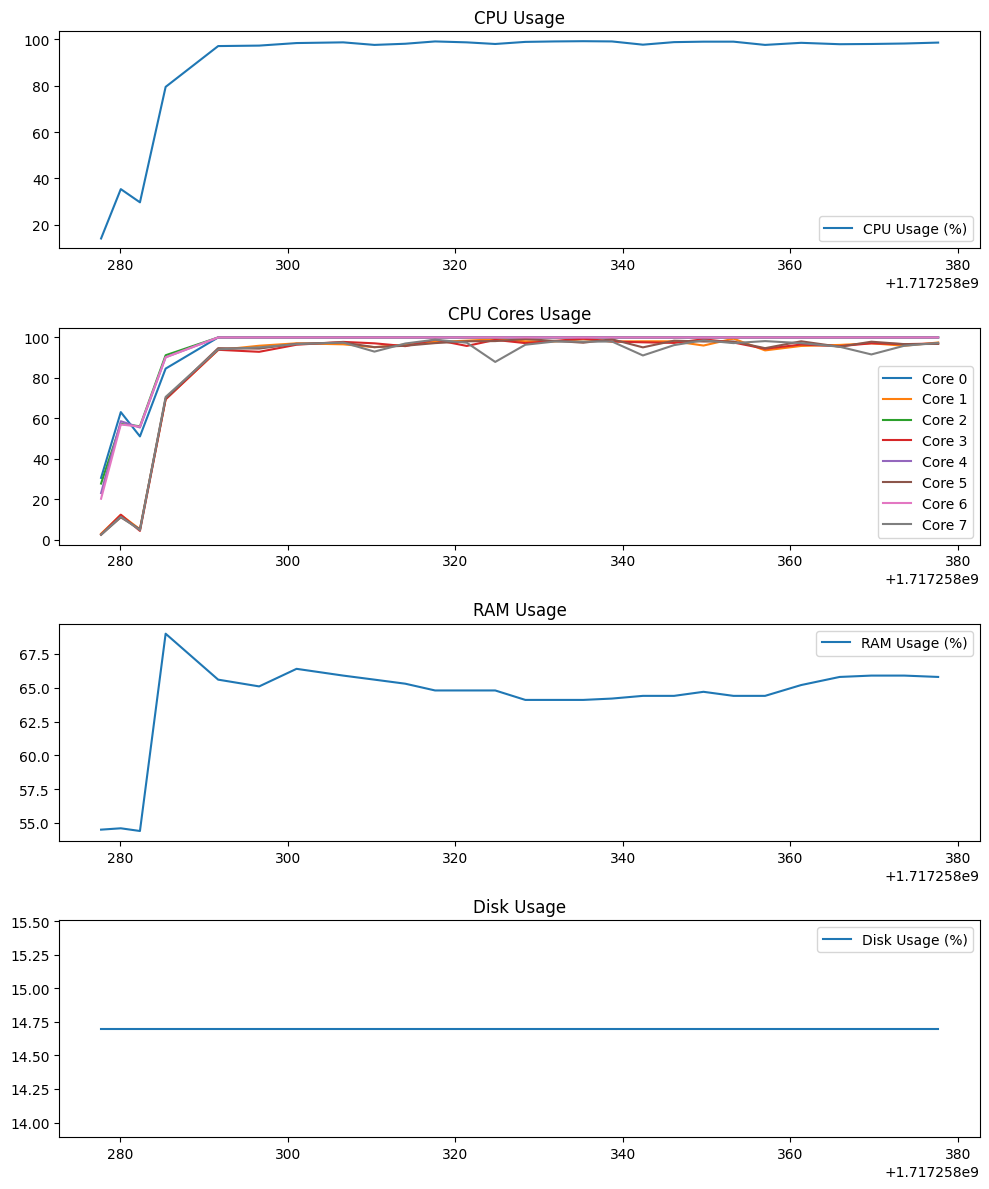

# 7# N = 437 = 19 * 23

In [34]:
N = 437
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 100.31 sec
*** Non-trivial factor found: 19 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:56 #
    ----------------------
    


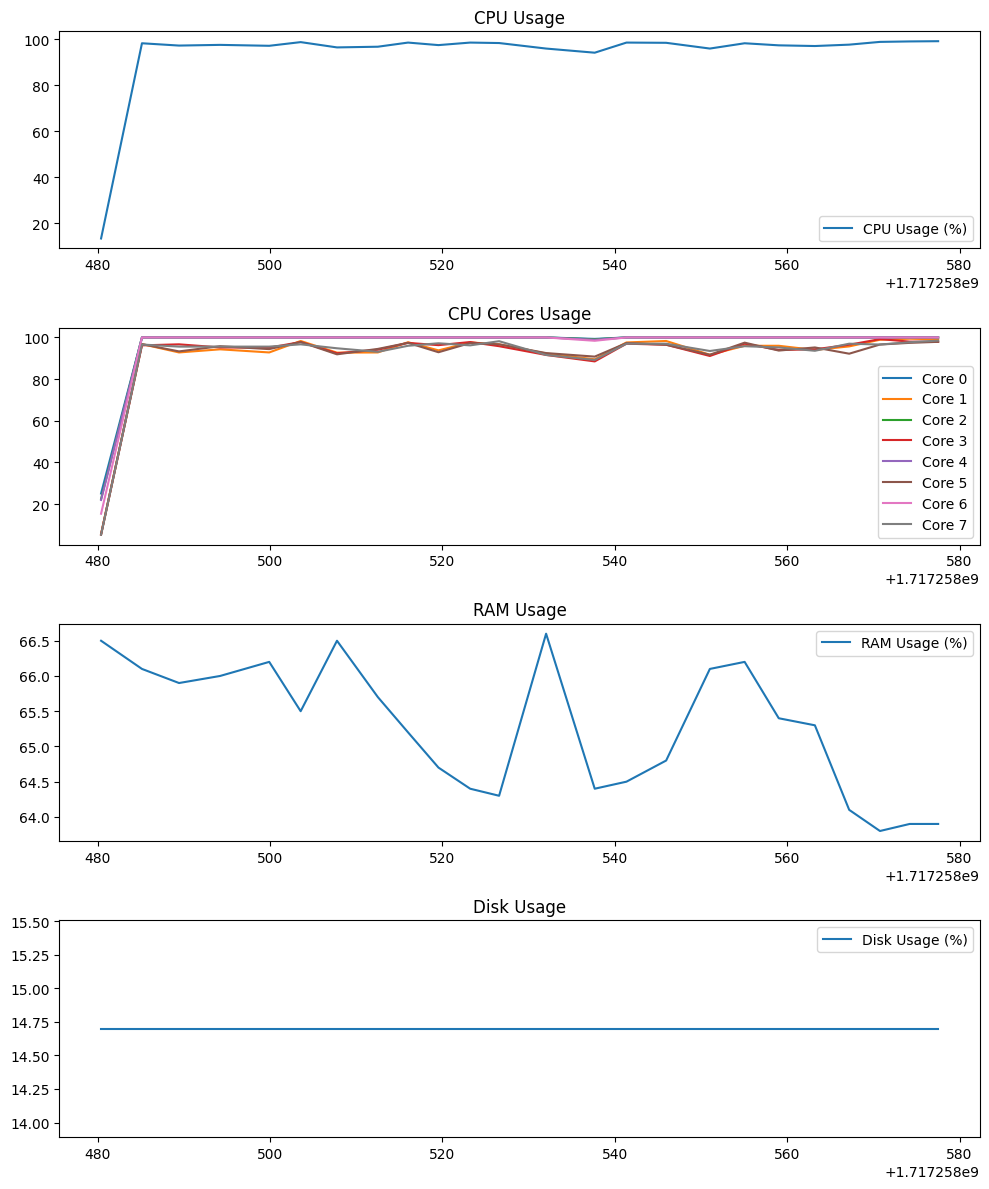

# 8# N = 667 = 23 * 29

In [ ]:
N = 667
test_shor_circuit(N, verbose=False, shots=100)